In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os, sys
import pandas as pd
import imblearn
from IPython.display import display

In [2]:
label_classes = {
    '(30, 32)': 0,
    '(25, 32)': 1,
    '(20, 32)': 2,
    '(15, 32)': 3,
    '(10, 32)': 4,
    '(5, 32)': 5,
    '(0, 0)': 6,
    '(5, 16)': 7,
    '(10, 16)': 8,
    '(15, 16)': 9,
    '(20, 16)': 10,
    '(25, 16)': 11,
    '(30, 16)': 12
}

In [3]:
NUM_IMGS = len(list(os.listdir('client/training_data5')))-1
imgs = np.empty((NUM_IMGS,384,256,3), dtype=np.uint8)
index = np.empty(NUM_IMGS).astype(int)
labels = np.empty((NUM_IMGS, 2)).astype(int)

In [4]:
for i, file in enumerate(os.listdir('client/training_data5')):
    if file[-3:] == 'png':
        imgs[i] = np.array(Image.open(f'client/training_data5/{file}'))
        index[i] = file[:-4]

In [5]:
with open('client/training_data5/labels.txt') as l:
    i = 0
    for line in l.readlines():
        if line == 'skipped dump\n':
            pass
        else:
            label, key = line.split('; ')
            key = label_classes[key[:-1]]
            labels[i] = (label, key)
            i += 1

In [6]:
NUM_IMGS = len(list(os.listdir('client/training_data55')))-1
imgs2 = np.empty((NUM_IMGS,384,256,3), dtype=np.uint8)
index2 = np.empty(NUM_IMGS+2000).astype(int)
labels2 = np.empty((NUM_IMGS+2000, 2)).astype(int)
UNIQUE_OFFSET = 50000000

In [7]:
for i, file in enumerate(os.listdir('client/training_data55/')):
    if file[-3:] == 'png':
        imgs2[i] = np.array(Image.open(f'client/training_data55/{file}'))
        index2[i] = file[:-4]
index2 += UNIQUE_OFFSET

In [8]:
with open('client/training_data55/labels.txt') as l:
    i = 0
    for line in l.readlines():
        if line == 'skipped dump\n':
            pass
        else:
            label, key = line.split('; ')
            key = label_classes[key[:-1]]
            labels2[i] = (label, key)
            i += 1
labels2[:,0] += UNIQUE_OFFSET

In [9]:
index = np.append(index, index2, axis=0)
imgs = np.append(imgs, imgs2, axis=0)
labels = np.append(labels, labels2, axis=0)

In [10]:
labels.shape

(15691, 2)

In [11]:
index = pd.DataFrame(index, columns=['UID'])
labels = pd.DataFrame(labels, columns=['UID', 'target'])
index = index[index['UID'] > UNIQUE_OFFSET]
labels = labels[labels['UID'] > UNIQUE_OFFSET]

In [7]:
# Cut the images to bottoms screen only!
imgs = imgs[:,192:,:,:]

In [12]:
Y = index.merge(labels, how='left', left_on='UID', right_on='UID').drop('UID', axis=1)
Y = Y[Y['target'].notna()]
Y['target'] = Y['target'].astype(np.uint8)

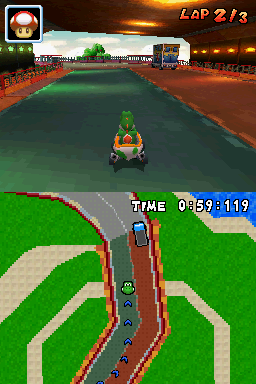

target    0
Name: 13631, dtype: uint8


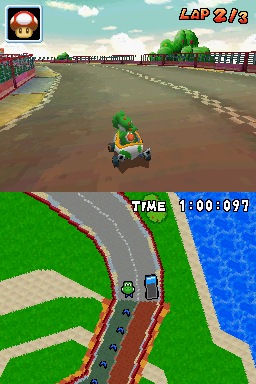

target    7
Name: 13632, dtype: uint8


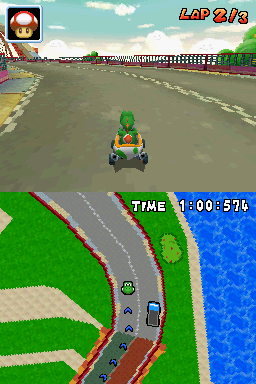

target    2
Name: 13633, dtype: uint8


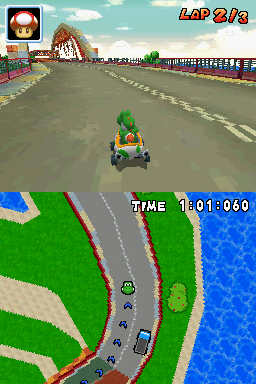

target    6
Name: 13634, dtype: uint8


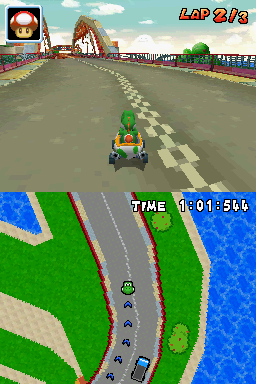

target    6
Name: 13635, dtype: uint8


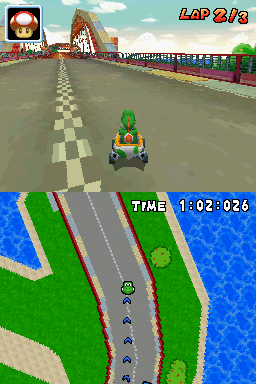

target    0
Name: 13636, dtype: uint8


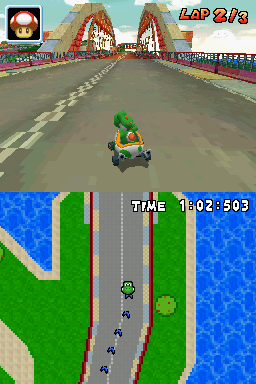

target    7
Name: 13637, dtype: uint8


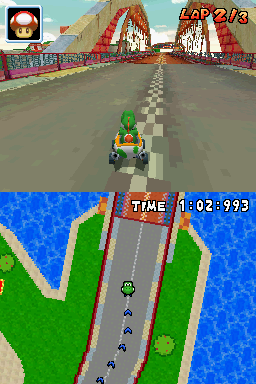

target    4
Name: 13638, dtype: uint8


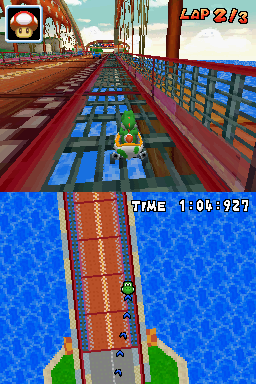

target    3
Name: 13639, dtype: uint8


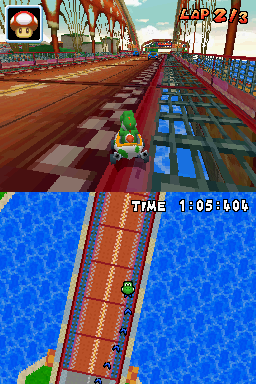

target    7
Name: 13640, dtype: uint8


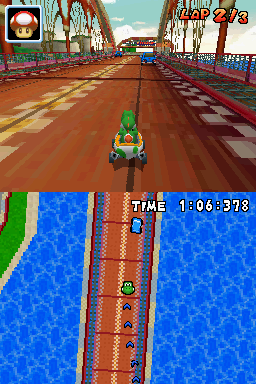

target    9
Name: 13641, dtype: uint8


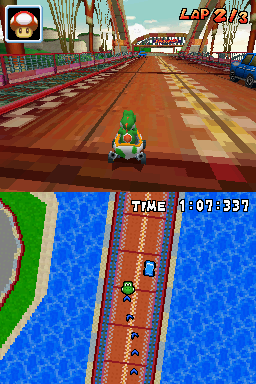

target    6
Name: 13642, dtype: uint8


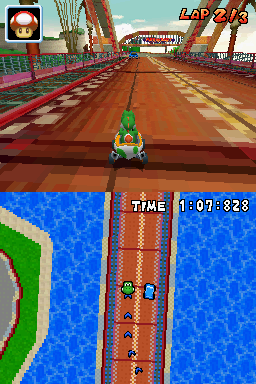

target    6
Name: 13643, dtype: uint8


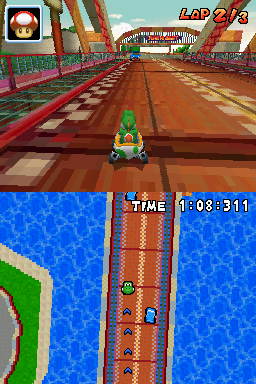

target    6
Name: 13644, dtype: uint8


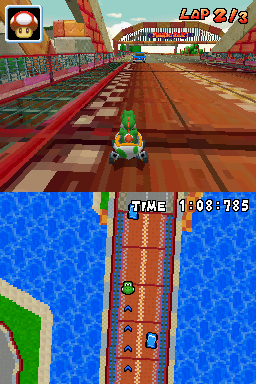

target    8
Name: 13645, dtype: uint8


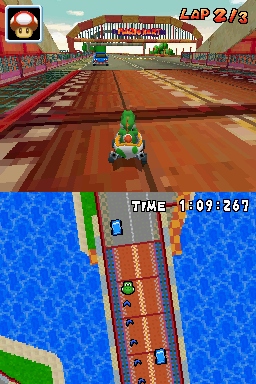

target    6
Name: 13646, dtype: uint8


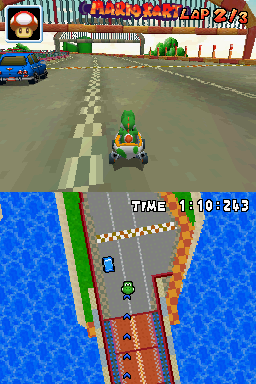

target    6
Name: 13647, dtype: uint8


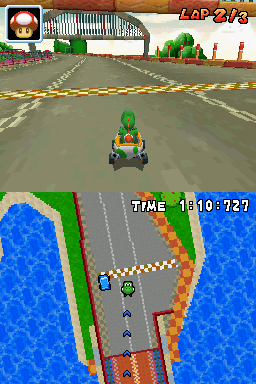

target    3
Name: 13648, dtype: uint8


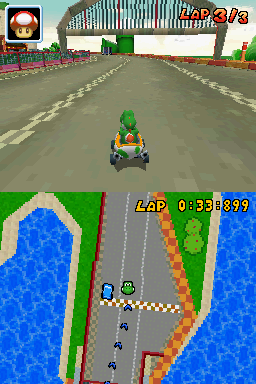

target    8
Name: 13649, dtype: uint8


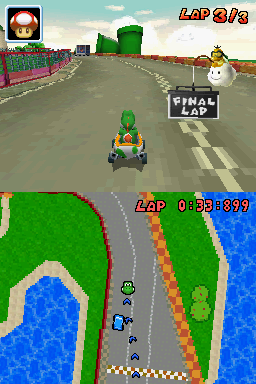

target    6
Name: 13650, dtype: uint8


In [13]:
for i in range(-60,-40):
    
    display(Image.fromarray(imgs[i]))
    print(Y.iloc[i])

In [14]:
from tensorflow.keras.utils import to_categorical
Y_onehot = to_categorical(Y).astype(np.uint8)

In [15]:
Y_onehot.shape

(13691, 13)

In [21]:
imgs.reshape(-1,294912).shape

(15847, 294912)

In [22]:
Y_onehot.dtype

dtype('uint8')

In [16]:
# from imblearn.over_sampling import RandomOverSampler, SMOTE
# sm = RandomOverSampler(sampling_strategy={
#     8: 1000,
#     9: 700,
#     10: 700,
#     11: 700,
#     12: 700
# })
# Xres, yres = sm.fit_resample(imgs.reshape(-1,294912), Y_onehot)
# X = Xres.reshape(-1,384,256,3)

C:\Users\santo\miniconda3\envs\mariotrain\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [17]:
Counter(np.argmax(Y_onehot,axis=-1))

NameError: name 'Counter' is not defined

In [18]:
from collections import Counter
Counter(np.argmax(yres,axis=-1))

Counter({6: 9061,
         3: 1112,
         5: 1235,
         4: 1280,
         0: 1550,
         7: 1079,
         8: 1000,
         11: 700,
         1: 466,
         2: 802,
         10: 700,
         9: 700,
         12: 700})

In [14]:
from sklearn.model_selection import train_test_split
Xtrain, Xval, ytrain, yval = train_test_split(imgs,Y_onehot)

In [24]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import BatchNormalization, Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras import optimizers
model = models.Sequential()

model.add(BatchNormalization(input_shape=(384, 256, 3)))
model.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(1164, activation='relu'))
drop_out = 1 - 0.6
model.add(Dropout(drop_out))
model.add(Dense(100, activation='relu'))
model.add(Dropout(drop_out))
model.add(Dense(50, activation='relu'))
model.add(Dropout(drop_out))
model.add(Dense(10, activation='relu'))
model.add(Dropout(drop_out))
model.add(Dense(13, activation='softmax', name="predictions"))

In [57]:
# model = models.Sequential()

# model.add(BatchNormalization(input_shape=(384, 256, 3)))
# model.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
# model.add(MaxPooling2D(strides=(3,3)))
# model.add(BatchNormalization())
# model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
# model.add(MaxPooling2D(strides=(3,3)))
# model.add(Flatten())
# model.add(Dense(1164, activation='relu'))
# drop_out = 1 - 0.6
# model.add(Dropout(drop_out))
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(drop_out))
# model.add(Dense(50, activation='relu'))
# model.add(Dropout(drop_out))
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(drop_out))
# model.add(Dense(13, activation='softmax', name="predictions"))

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_10 (Batc (None, 384, 256, 3)       12        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 190, 126, 24)      1824      
_________________________________________________________________
batch_normalization_11 (Batc (None, 190, 126, 24)      96        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 93, 61, 36)        21636     
_________________________________________________________________
batch_normalization_12 (Batc (None, 93, 61, 36)        144       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 45, 29, 48)        43248     
_________________________________________________________________
batch_normalization_13 (Batc (None, 45, 29, 48)       

In [26]:
epochs = 100
batch_size = 32

In [27]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])

In [28]:
model.fit(imgs, Y_onehot, batch_size=batch_size, epochs=epochs, 
          shuffle=True)

Epoch 1/100
428/428 [==============================] - 42s 98ms/step - loss: 2.4738 - accuracy: 0.2921
Epoch 2/100
428/428 [==============================] - 42s 98ms/step - loss: 2.1581 - accuracy: 0.3960
Epoch 3/100
428/428 [==============================] - 41s 96ms/step - loss: 2.0496 - accuracy: 0.4279
Epoch 4/100
428/428 [==============================] - 42s 97ms/step - loss: 1.9429 - accuracy: 0.4455
Epoch 5/100
428/428 [==============================] - 41s 96ms/step - loss: 1.8844 - accuracy: 0.4513
Epoch 6/100
428/428 [==============================] - 41s 96ms/step - loss: 1.8154 - accuracy: 0.4607
Epoch 7/100
428/428 [==============================] - 41s 96ms/step - loss: 1.7635 - accuracy: 0.4623
Epoch 8/100
428/428 [==============================] - 41s 96ms/step - loss: 1.7044 - accuracy: 0.4656
Epoch 9/100
428/428 [==============================] - 41s 96ms/step - loss: 1.6392 - accuracy: 0.4706
Epoch 10/100
428/428 [==============================] - 41s 96ms/step - l

428/428 [==============================] - 41s 96ms/step - loss: 0.8228 - accuracy: 0.6924
Epoch 80/100
428/428 [==============================] - 41s 97ms/step - loss: 0.8270 - accuracy: 0.6932
Epoch 81/100
428/428 [==============================] - 41s 96ms/step - loss: 0.8306 - accuracy: 0.6916
Epoch 82/100
428/428 [==============================] - 41s 97ms/step - loss: 0.7915 - accuracy: 0.6985
Epoch 83/100
428/428 [==============================] - 41s 96ms/step - loss: 0.7981 - accuracy: 0.7056
Epoch 84/100
428/428 [==============================] - 41s 97ms/step - loss: 0.7999 - accuracy: 0.7002
Epoch 85/100
428/428 [==============================] - 41s 96ms/step - loss: 0.8020 - accuracy: 0.7016
Epoch 86/100
428/428 [==============================] - 41s 97ms/step - loss: 0.7972 - accuracy: 0.6986
Epoch 87/100
428/428 [==============================] - 41s 97ms/step - loss: 0.7978 - accuracy: 0.7046
Epoch 88/100
428/428 [==============================] - 41s 96ms/step - loss:

In [29]:
model.save('bridgemodel.h5')

In [15]:
model.save('model.h5')

In [16]:
imgs[0]

array([[[232, 248, 112],
        [232, 248, 112],
        [232, 248, 112],
        ...,
        [232, 248, 112],
        [232, 248, 112],
        [232, 248, 112]],

       [[232, 248, 112],
        [232, 248, 112],
        [232, 248, 112],
        ...,
        [232, 248, 112],
        [232, 248, 112],
        [232, 248, 112]],

       [[232, 248, 112],
        [232, 248, 112],
        [232, 248, 112],
        ...,
        [232, 248, 112],
        [232, 248, 112],
        [232, 248, 112]],

       ...,

       [[192, 176,  48],
        [192, 176,  48],
        [192, 176,  48],
        ...,
        [  0, 152,   0],
        [  0, 152,   0],
        [  0, 152,   0]],

       [[192, 176,  48],
        [192, 176,  48],
        [192, 176,  48],
        ...,
        [  0, 152,   0],
        [  0, 152,   0],
        [  0, 152,   0]],

       [[192, 176,  48],
        [192, 176,  48],
        [192, 176,  48],
        ...,
        [  0, 136,   0],
        [  0, 136,   0],
        [  0, 152,   0]]

In [17]:
Xtrain[0].shape

(384, 256, 3)

In [18]:
Xtrain[0].reshape((1,384,256,3))

array([[[[232, 248, 112],
         [232, 248, 112],
         [232, 248, 112],
         ...,
         [232, 248, 112],
         [232, 248, 112],
         [232, 248, 112]],

        [[232, 248, 112],
         [232, 248, 112],
         [232, 248, 112],
         ...,
         [232, 248, 112],
         [232, 248, 112],
         [232, 248, 112]],

        [[232, 248, 112],
         [232, 248, 112],
         [232, 248, 112],
         ...,
         [232, 248, 112],
         [232, 248, 112],
         [232, 248, 112]],

        ...,

        [[192, 176,  48],
         [192, 176,  48],
         [184, 168,  40],
         ...,
         [  0, 144,   0],
         [  0, 144,   0],
         [  0, 152,   0]],

        [[176, 160,  32],
         [184, 168,  40],
         [184, 168,  40],
         ...,
         [  0, 144,   0],
         [  0, 144,   0],
         [  0, 144,   0]],

        [[176, 160,  32],
         [176, 160,  32],
         [176, 160,  32],
         ...,
         [  0, 144,   0],
        

In [19]:
np.argmax(model.predict(Xtrain[0].reshape((1,384,256,3))))

4

In [43]:
b = np.argmax(model.predict(Xval), axis=-1)

In [21]:
p = model.predict(Xtrain)

In [22]:
p[1]

array([4.0490393e-09, 7.8381709e-06, 4.5282941e-06, 1.6496315e-08,
       1.3009969e-08, 1.0554494e-09, 9.9998760e-01, 6.9509616e-15,
       3.1997585e-19, 8.8328350e-10, 1.3140471e-16, 9.4862356e-13,
       6.3696518e-14], dtype=float32)

In [23]:
import matplotlib.pyplot as plt

In [24]:
sum(b == 13)

0

In [25]:
ytrain

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
Y['target'] == 6

0        True
1        True
2       False
3       False
4       False
        ...  
3447     True
3448     True
3449    False
3450     True
3451     True
Name: target, Length: 3452, dtype: bool

In [27]:
sum(b==2)

68

(array([ 386.,  152.,  230.,  263.,  233., 1894.,   96.,   52.,   54.,
          92.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

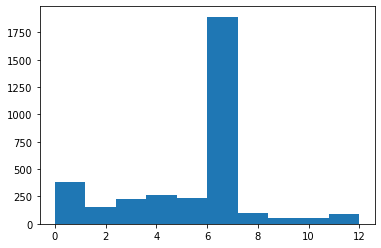

In [28]:
import matplotlib.pyplot as plt
plt.hist(Y['target'])

In [44]:
from collections import Counter
Counter(b)

Counter({6: 4699, 10: 665, 8: 312, 12: 451})

(array([4699.,    0.,    0.,  312.,    0.,    0.,  665.,    0.,    0.,
         451.]),
 array([ 6. ,  6.6,  7.2,  7.8,  8.4,  9. ,  9.6, 10.2, 10.8, 11.4, 12. ]),
 <BarContainer object of 10 artists>)

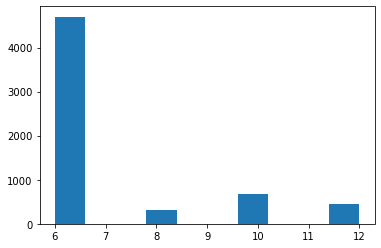

In [45]:
import matplotlib.pyplot as plt
plt.hist(b)

In [30]:
sum(b==1)

0

In [31]:
ytrain[3]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [3]:
model = tf.keras.models.load_model('server/brownmodel.h5')

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 192, 256, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 94, 126, 24)       1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 94, 126, 24)       96        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 61, 36)        21636     
_________________________________________________________________
batch_normalization_2 (Batch (None, 45, 61, 36)        144       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 29, 48)        43248     
_________________________________________________________________
batch_normalization_3 (Batch (None, 21, 29, 48)        1

In [81]:
viz = tf.keras.Model(inputs=model.inputs, outputs=[model.layers[i].output for i in [2,4,6,8,10]])

In [82]:
fmap = np.array(Image.open(f'client/training_data2/1601944694.png')).reshape(1,384,256,3)[:,192:,:,:]

In [83]:
fmaps = viz(fmap)

In [84]:
len(fmaps)

5

In [68]:
fmaps[0].numpy()[0,:,:,1]

array([[0.        , 0.        , 0.        , ..., 2.6415753 , 3.612327  ,
        0.        ],
       [0.22610848, 0.        , 0.        , ..., 3.7040088 , 2.8844295 ,
        0.        ],
       [0.        , 0.06169304, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.04572769, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01484048, 0.0710555 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03120438, 0.14788467, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [59]:
def image_histogram_equalization(image, number_bins=256):
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape), cdf

InvalidArgumentError: Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/

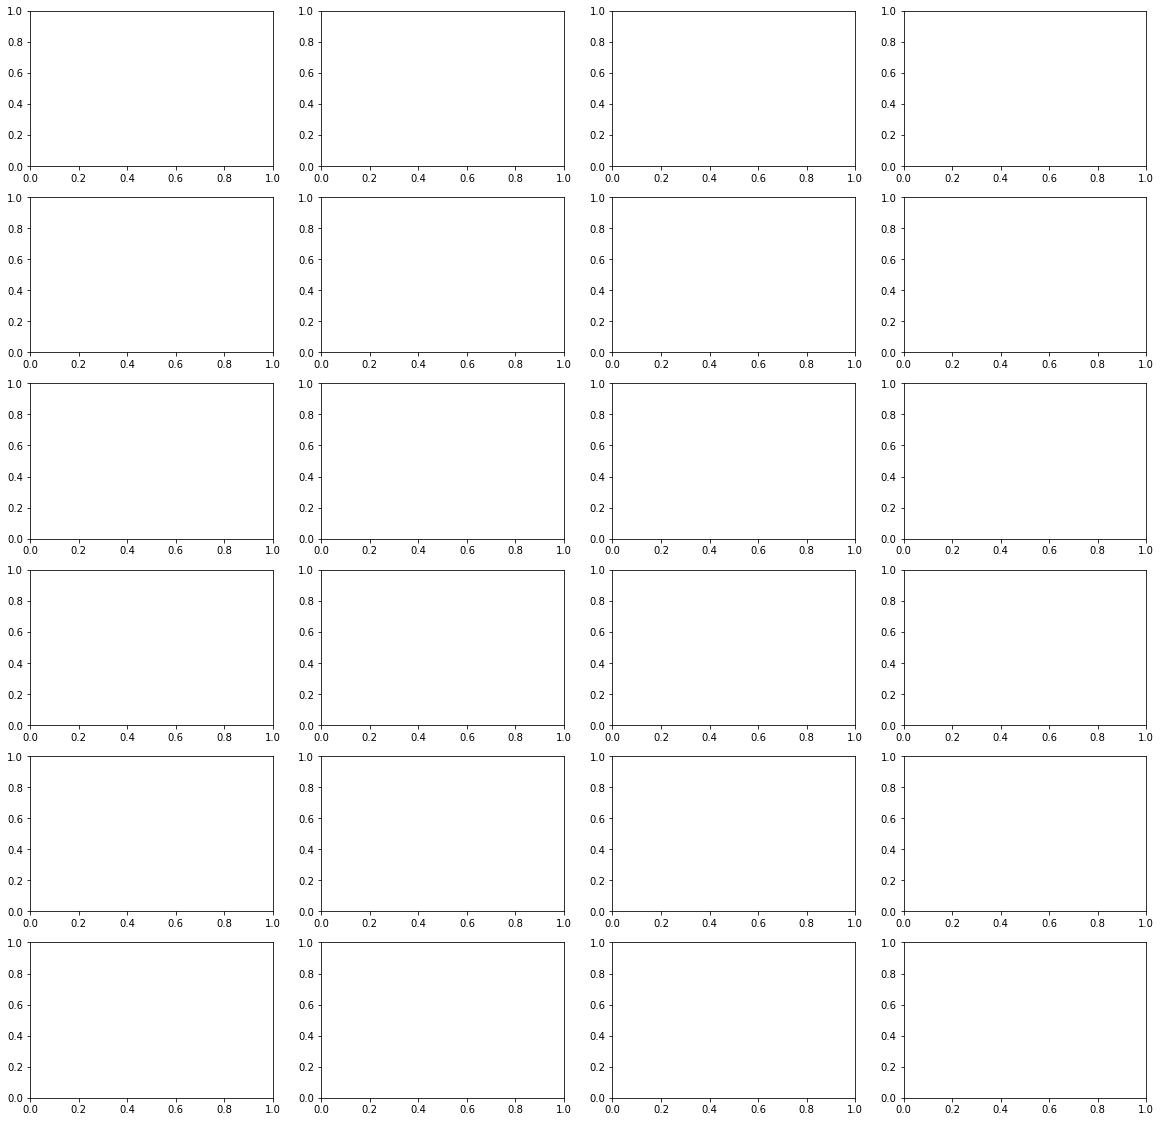

In [90]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(6,4, figsize=(20,20))
q = 0
for i in range(6):
    for j in range(4):
        k = fmaps[4][0,:,:,q].numpy()
        p, _ = image_histogram_equalization(k)
        ax[i,j].imshow(p, cmap='gray', aspect='auto')
        q += 1